<a href="https://colab.research.google.com/github/claudiohfg/notebooks/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from IPython.display import display
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
from xgboost import XGBClassifier

In [ ]:
warnings.simplefilter(action='ignore', category=sk.exceptions.ConvergenceWarning)

# Utility Functions

In [ ]:
def abs_scaler(ds: pd.DataFrame) -> pd.DataFrame:
    """
    Receive a dataframe, apply MaxAbsScaler transformation
    and return the dataset with the same columns and data
    in the same scale for analysis purposes.

    >>> abs_scaler(pd.DataFrame(
        (np.random.rand(10, 3) * 100),
        columns=['A', 'B', 'C']
    )).max().values == np.array([1., 1., 1.])
    np

    Parameters
    ----------
    ds : pd.DataFrame
        Dataset to be scaled.
    
    Returns
    -------
    ds : pd.DataFrame
        Scaled dataset.
    """
    
    arr = MaxAbsScaler().fit_transform(ds.values)
    return pd.DataFrame(arr, columns=ds.columns)

In [ ]:
def label_feature(
    ds: pd.DataFrame,
    feature: str,
    n_parts: int,
    qcut=True) -> pd.DataFrame:
    """
    Generates label feature either distributing
    data equally or normally.

    Parameters
    ----------
    ds : pd.DataFrame
        Dataset to be scaled.
    
    Returns
    -------
    ds : pd.DataFrame
        Scaled dataset.
    """
    
    feat_sparse = f"{feature}_label"
    feat_label = f"{feature}_lbl"

    if qcut:
        ds[feat_sparse] = pd.qcut(ds[feature], n_parts)
    else:
        ds[feat_sparse] = pd.cut(ds[feature], n_parts)

    ds[feat_label] = LabelEncoder().fit_transform(ds[feat_sparse])
    ds.drop(labels=[feat_sparse], axis=1, inplace=True)

    return ds

In [ ]:
def quantify_features(
    ds: pd.DataFrame,
    verbose=True,
    correlation_threshold=0.9
) -> pd.DataFrame:
    """
    Automatically selections features to quantify,
    analyses how they should be quantified, label encode
    the features and select the ones that should remain
    considering the correlation to the original features.

    Parameters
    ----------
    ds : pd.DataFrame
        Dataset to be scaled.
    verbose : Boolean
        If there should be an output or not.
    correlation_threshold : float
        The limit above which the feature should be dropped.
    
    Returns
    -------
    ds : pd.DataFrame
        Dataset with new quantified features.
    """
    features_to_quantize = []

    for feature in ds.columns:
        if feature == 'target':
            continue
            
        _mean = np.round(ds[feature].mean(), 2)
        _stddev = np.round(ds[feature].std(), 2)

        if _stddev == 0:
            continue

        _max = np.round(ds[feature].max(), 2)
        _min = np.round(ds[feature].min(), 2)

        _ofs_max = (_max - _mean)/_stddev
        _ofs_min = (_mean - _min)/_stddev

        if _ofs_max > 3 or _ofs_min > 3:
            n_parts = 5 if np.log10(_stddev) < 2 else 10
            equally = False if _ofs_max < 10 and _ofs_min < 10 else True
            
            features_to_quantize.append([feature, n_parts, equally])

        if verbose:
            ds[[feature]].plot(figsize=(10, 3), title=feature, kind='kde')
            plt.show()
    
    if verbose:
        display(
            pd.DataFrame(
                features_to_quantize,
                columns=['Feature', 'N Parts', 'Equally']
            )
        )

    for [feature, parts, equally] in features_to_quantize:
        ds = label_feature(ds, feature, parts, equally)

    ds_corr = ds.corr()

    for [feat, feat_lbl] in [
        ['_'.join(col.split('_')[:-1]), col]
        for col in df.columns
        if '_lbl' in col
    ]:
        if ds_corr.loc[feat, feat_lbl] >= correlation_threshold:
            ds.drop(columns=[feat_lbl], inplace=True)
            if verbose:
                print(f'Dropping {feat_lbl}')
    
    return ds

# Loading

In [ ]:
data = load_breast_cancer()

In [ ]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Substitute spaces for underdashes in features names to allow us to access them without the use of brackets.

In [ ]:
features = [feature.replace(' ', '_') for feature in data.feature_names]

df = pd.DataFrame(
    data.data,
    columns=features)

df['target'] = data.target

In [ ]:
df.head(n=10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


# Analysing

In [ ]:
df.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


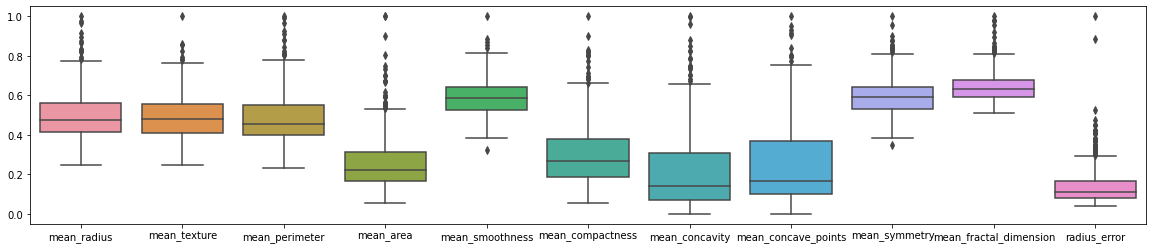

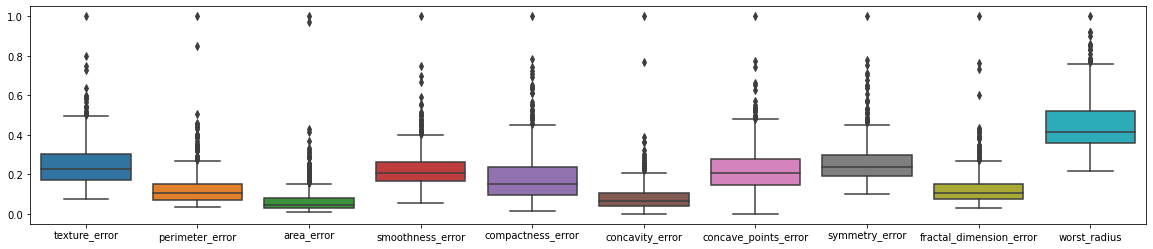

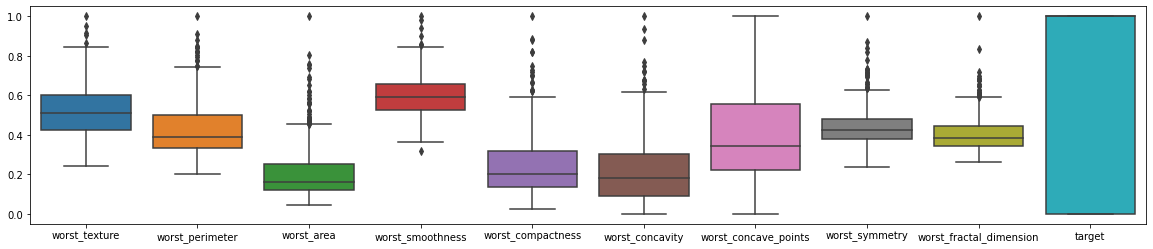

In [ ]:
df_scl = abs_scaler(df)
columns_splits = np.array_split(df.columns, 3)

for columns in columns_splits:
    fig, ax = plt.subplots(figsize=(20, 4))
    g = sns.boxplot(
        data=df_scl[columns]
    )
    plt.show()

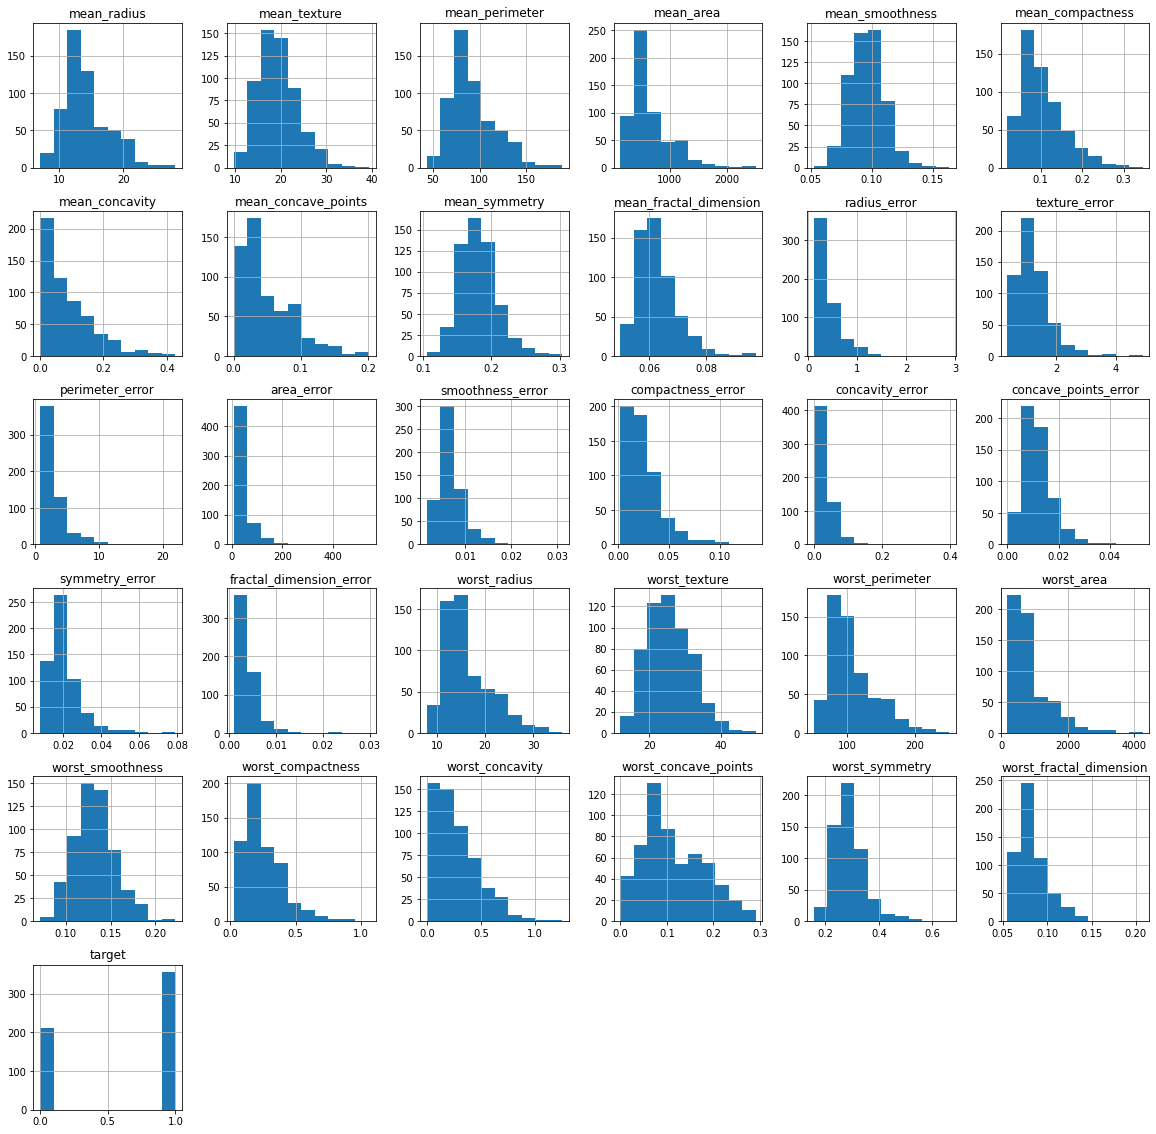

In [ ]:
df.hist(figsize=(20, 20))
plt.show()

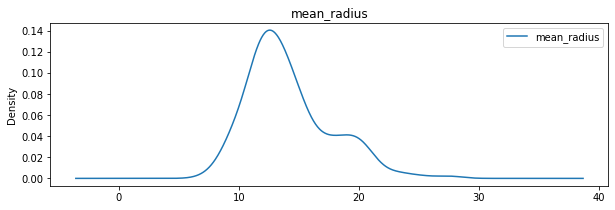

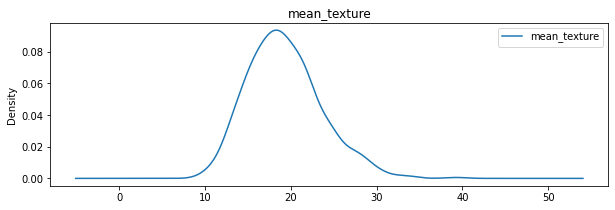

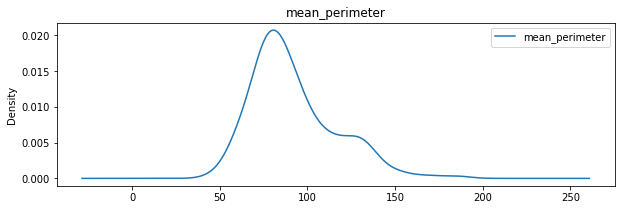

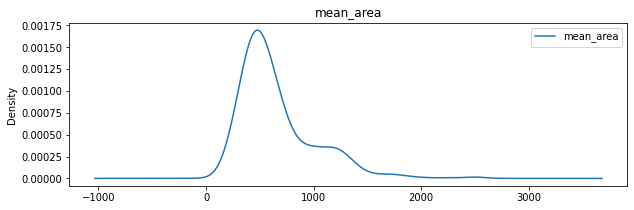

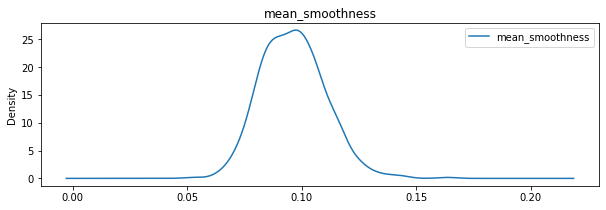

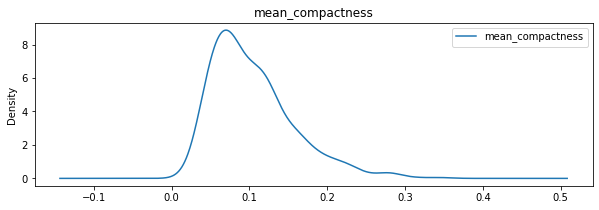

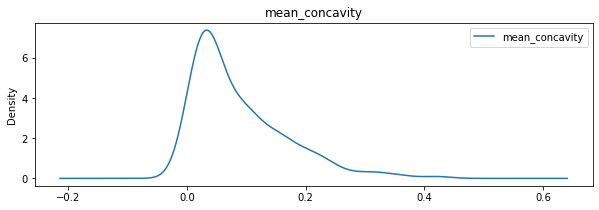

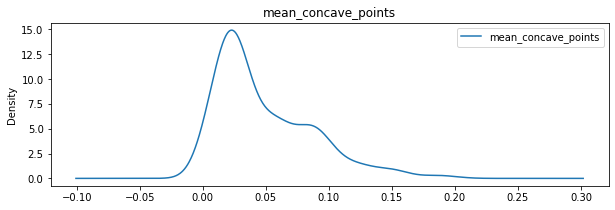

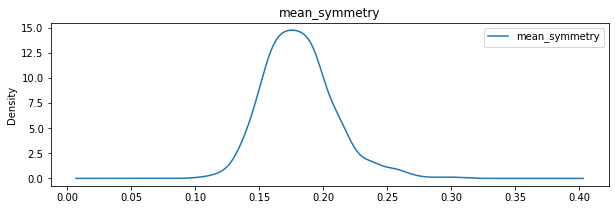

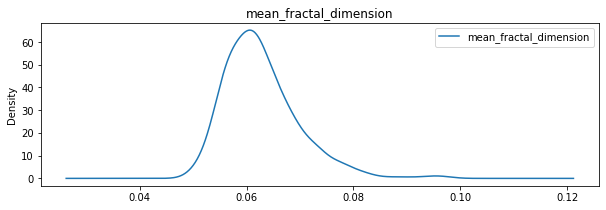

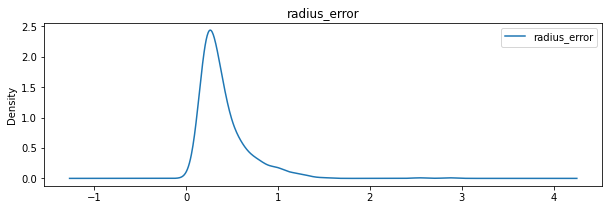

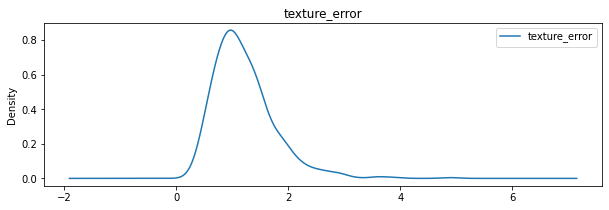

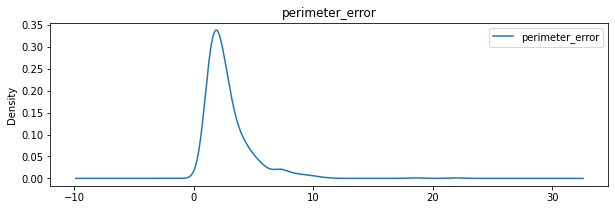

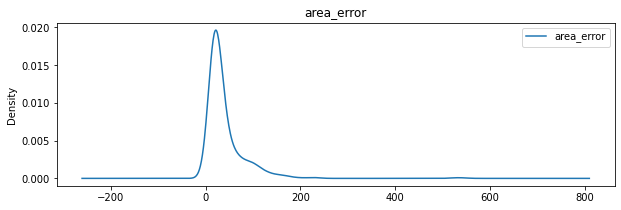

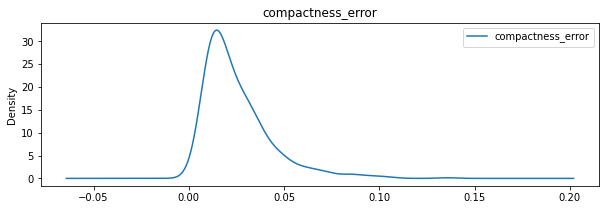

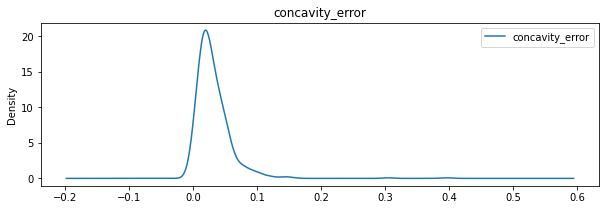

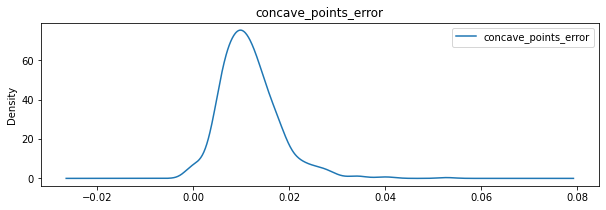

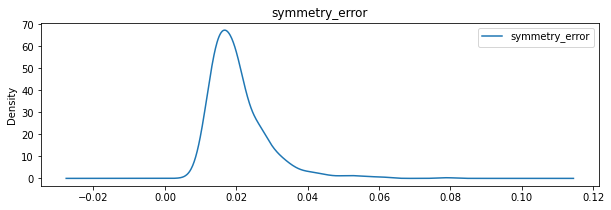

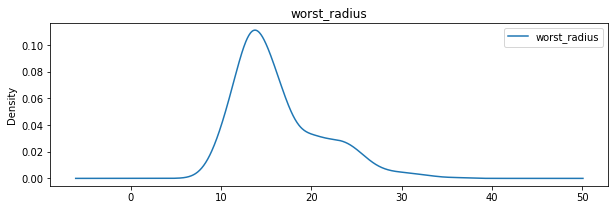

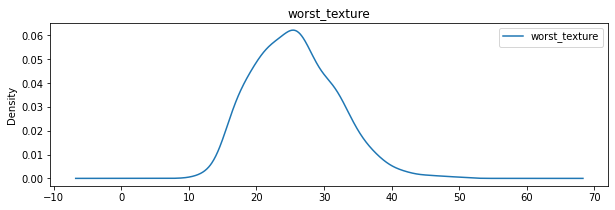

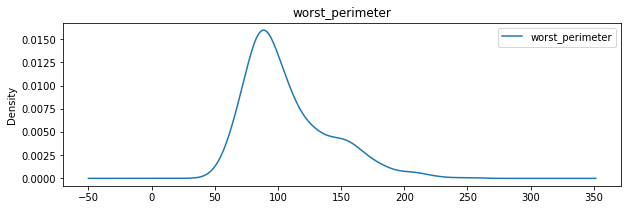

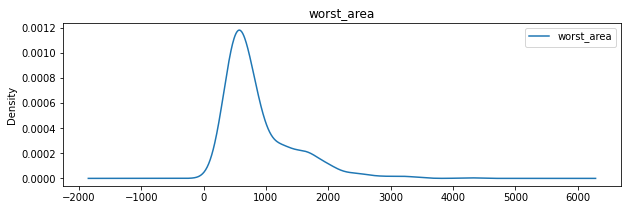

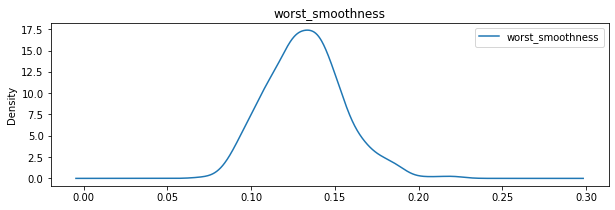

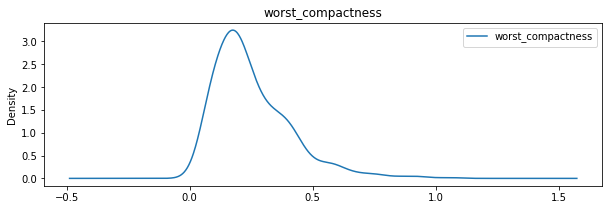

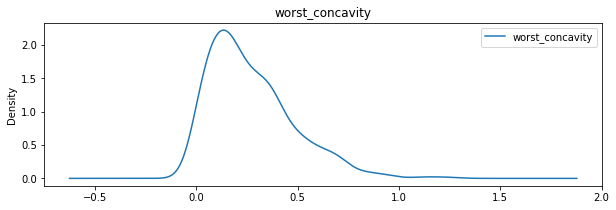

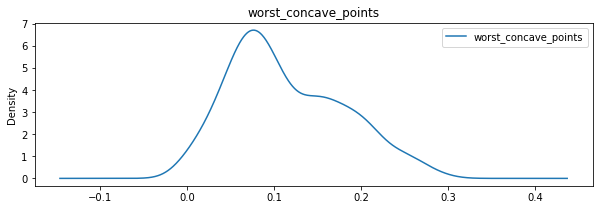

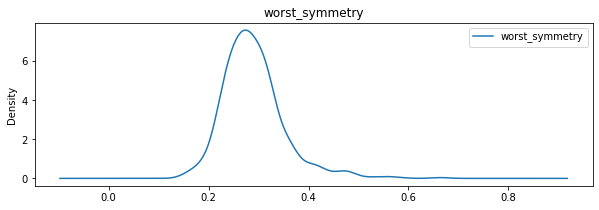

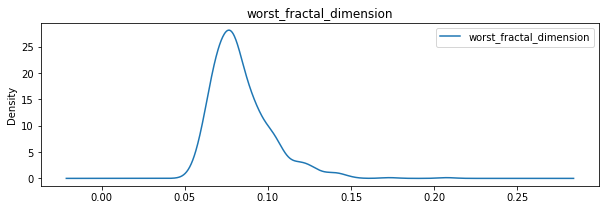

,Feature,N Parts,Equally
0,mean_radius,5,False
1,mean_texture,5,False
2,mean_perimeter,5,False
3,mean_area,10,False
4,mean_smoothness,5,False
5,mean_compactness,5,False
6,mean_concavity,5,False
7,mean_concave_points,5,False
8,mean_symmetry,5,False
9,mean_fractal_dimension,5,False


Dropping mean_radius_lbl
Dropping mean_texture_lbl
Dropping mean_perimeter_lbl
Dropping mean_area_lbl
Dropping mean_smoothness_lbl
Dropping mean_compactness_lbl
Dropping mean_concavity_lbl
Dropping mean_concave_points_lbl
Dropping mean_symmetry_lbl
Dropping mean_fractal_dimension_lbl
Dropping texture_error_lbl
Dropping compactness_error_lbl
Dropping symmetry_error_lbl
Dropping worst_radius_lbl
Dropping worst_texture_lbl
Dropping worst_perimeter_lbl
Dropping worst_area_lbl
Dropping worst_smoothness_lbl
Dropping worst_compactness_lbl
Dropping worst_concavity_lbl
Dropping worst_symmetry_lbl
Dropping worst_fractal_dimension_lbl


In [ ]:
df = quantify_features(df)

In [ ]:
df_corr = df.corr()
arr = list(df_corr.loc['target'].items())
arr.sort(key=lambda x: np.abs(x[1]), reverse=True)
columns = [x[0] for x in arr if np.abs(np.round(x[1], 2)) >= 0.05]
df = df[columns].copy()

# Splitting

In [ ]:
eval = df.sample(frac=0.2).index

df_train = df.drop(index=eval)
df_eval = df.iloc[eval]

X_train = df_train.drop(labels='target', axis=1).values
y_train = df_train['target'].values

X_eval = df_eval.drop(labels='target', axis=1).values
y_eval = df_eval['target'].values

# Scaling

In [ ]:
scaler = Pipeline([
    ('StandardScaler', StandardScaler()),
    # ('MaxAbsScaler', MaxAbsScaler())
])

scaler.fit(X_train, y_train)

X_train_scaled = scaler.transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

# Clustering feature creation

In [ ]:
result = []

for n_clusters in tqdm(range(
    X_train_scaled.shape[1]//2,
    X_train_scaled.shape[1])):
    kmeans = KMeans(n_clusters=n_clusters).fit(X_train_scaled, y_train)
    score = silhouette_score(
        X_train_scaled,
        kmeans.fit_predict(X_train_scaled, y_train))
    result.append([n_clusters, score])

result.sort(key=lambda x: x[1], reverse=True)

print(f'Best score with {result[0][0]} clusters.')

kmeans = KMeans(n_clusters=result[0][0]).fit(X_train_scaled, y_train)

100%|██████████| 16/16 [00:07<00:00,  2.24it/s]

Best score with 19 clusters.


In [ ]:
k_pred = kmeans.predict(X_train_scaled, y_train)
k_pred = k_pred / (result[0][0] - 1)

In [ ]:
X_train_scaled = np.concatenate(
    (
        X_train_scaled,
        np.reshape(k_pred, (k_pred.shape[0], 1))
    ), axis=1)

In [ ]:
k_pred = kmeans.predict(X_eval_scaled, y_eval)
k_pred = k_pred / (result[0][0] - 1)

In [ ]:
X_eval_scaled = np.concatenate(
    (
        X_eval_scaled,
        np.reshape(k_pred, (k_pred.shape[0], 1))
    ), axis=1)

# Model selection

In [ ]:
metric = make_scorer(accuracy_score, greater_is_better=True, needs_proba=False)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

In [ ]:
models = [
    ('LGBMClassifier', LGBMClassifier),
    ('XGBClassifier', XGBClassifier),
    ('RandomForest', RandomForestClassifier),
    ('MLPClassifier', MLPClassifier)
]

In [ ]:
params = [
    {
        'boosting_type': ['gbdt', 'dart', 'goss'],
        'num_leaves': [17, 31, 63],
        'learning_rate': [0.1, 1e-2, 1e-3],
        'n_estimators': [100, 150, 200, 250, 300],
    },
    {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.1, 1e-2, 1e-3],
        'booster': ['gbtree', 'gblinear', 'dart'],
        'n_jobs': [os.cpu_count()],
    },
    {
        'n_estimators': [100, 150, 200, 250, 300],
        'oob_score': [True, False],
        'criterion': ['gini', 'entropy'],
        'n_jobs': [-1],
    },
    {
        'hidden_layer_sizes': [(100,), (100, 100,), (200, 200,), (100, 100, 100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [200, 250, 300],
        'tol': [1e-4, 1e-5],
        'early_stopping': [True, False],
        'n_iter_no_change': [10, 15, 20],
    }
]

In [ ]:
best_params = []
scores = []

for idx in tqdm(range(len(models))):
    name, model = models[idx]
    rscv = RandomizedSearchCV(
        model(),
        params[idx],
        scoring='accuracy',
        n_iter=15,
        cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=0))
    rscv.fit(X_train_scaled, y_train)
    best_params.append(rscv.best_params_)
    scores.append(f'Model {name} \t Score {rscv.best_score_}')

print()

for score in scores:
    print(score)

100%|██████████| 4/4 [00:57<00:00, 14.47s/it]


Model LGBMClassifier 	 Score 0.9626031137446264
Model XGBClassifier 	 Score 0.9516236784013014
Model RandomForest 	 Score 0.9626031137446264
Model MLPClassifier 	 Score 0.9714331358196816


In [ ]:
best_models = [(name, model(**params)) for (name, model), params in list(zip(models, best_params))]

In [ ]:
result = []
scores = dict()

for name, model in tqdm(best_models):
    score = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1)
    scores[name] = sorted(score.tolist())
    result.append([name, np.abs(np.median(score)), np.std(score)])

100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


In [ ]:
result = pd.DataFrame(result, columns=['Model', 'Median', 'Stddev'])
result.sort_values(
    by=['Median', 'Stddev'],
    ascending=[False, True],
    inplace=True)
result.reset_index(drop=True, inplace=True)
display(result)

selected_model = list(filter(lambda x: x[0] == result.iloc[0, 0], best_models))[0][1]

,Model,Median,Stddev
0,MLPClassifier,0.989011,0.014579
1,LGBMClassifier,0.972527,0.024101
2,RandomForest,0.967033,0.024101
3,XGBClassifier,0.961538,0.019688


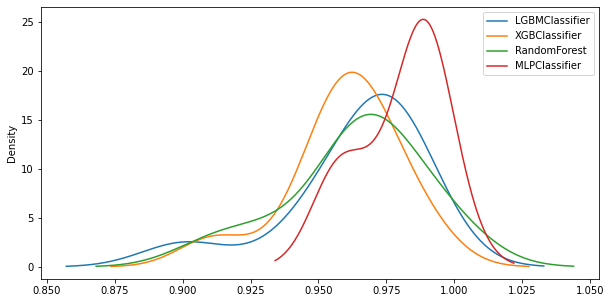

In [ ]:
pd.DataFrame(scores).plot(
    kind='kde',
    figsize=(10,5),
    xlabel='Predictions',
    ylabel='Score',
    sort_columns=True
)
plt.show()

# Evaluation

In [ ]:
selected_model.fit(X_train_scaled, y_train)
y_pred = selected_model.predict(X_eval_scaled)
print(f'Accuracy = {accuracy_score(y_eval, y_pred)}')

Accuracy = 0.9736842105263158
